In [342]:
from rockit import *
import numpy as np
import matplotlib.pyplot as plt

Problem setup:

In [343]:
ocp = Ocp(T=(FreeTime(0.0)))

x1 = ocp.state()
x2 = ocp.state()
x3 = ocp.state()

u = ocp.control()

Parameters:

In [344]:
mass_rider = 78
mass_bike = 8
m = mass_rider + mass_bike
g = 9.81
my = 0.004
b0 = 0.091
b1 = 0.0087
Iw = 0.14
r = 0.33
Cd = 0.7
rho = 1.2
A = 0.4
eta = 1
w_prime = 26630
cp = 265
track_length = 1000
s = 0.02


Derivatives:

In [345]:
ocp.set_der(x1, x2)
ocp.set_der(x2, 1/(x2) * 1/(m + Iw/r**2) * (eta*u - m*g*x2*s - my*m*g*x2 - b0*x2 - b1*x2**2 - 0.5*Cd*rho*A*x2**3))
ocp.set_der(x3, -(u-cp))

Set objectives:

In [346]:
ocp.add_objective(ocp.T)
#ocp.add_objective(ocp.integral(x2))

Add boundary constraints:

In [347]:
ocp.subject_to(ocp.at_t0(x1) == 0)
ocp.subject_to(ocp.at_t0(x2) == 1)
ocp.subject_to(ocp.at_t0(x3) == w_prime)
ocp.subject_to(ocp.at_tf(x1) == track_length)
#ocp.subject_to(ocp.at_t0(u) == 0)

Add path constraints:

In [348]:
ocp.subject_to(0 <= (u <= 500))
ocp.subject_to(0.1 <= (x2 <= 20))
#ocp.subject_to(0 <= (x3 <= w_prime))
ocp.subject_to(0 <= x3)
ocp.subject_to(0 <= (ocp.T <= 400))

Initial guesses:

In [349]:
ocp.set_initial(x2, 10)
ocp.set_initial(u, 250)
ocp.set_initial(ocp.T, 200)

Setup the solver:

In [350]:
opts = {"expand": True,
        "verbose": False,
        "print_time": True,
        "error_on_fail": True,
        "ipopt": {"linear_solver": "mumps",  # "ma57" is faster!
                  "max_iter": 5000,
                  'print_level': 5,
                  'sb': 'yes',  # Suppress IPOPT banner
                  'tol': 1e-3,
                  'hessian_approximation': 'limited-memory'
                  }}
ocp.solver("ipopt", opts)

method = MultipleShooting(N=20, intg='rk')
ocp.method(method)

In [351]:
sol = ocp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      264
Number of nonzeros in inequality constraint Jacobian.:       65
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       84
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       65
        inequality constraints with only lower bounds:       22
   inequality constraints with lower and upper bounds:       43
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e+02 2.66e+04 5.00e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

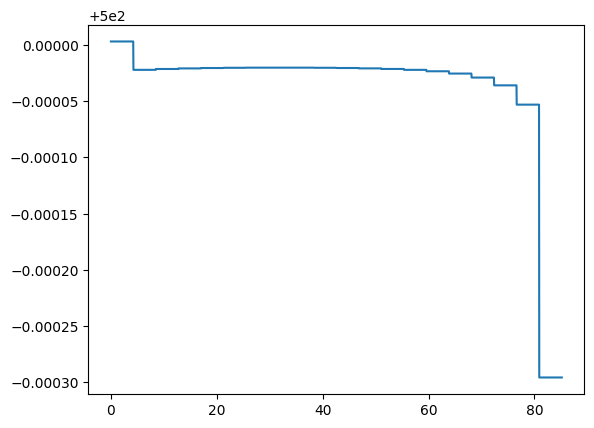

In [352]:
tsol, usol = sol.sample(u, grid='integrator', refine=100)
plt.plot(tsol, usol)
plt.show()

In [353]:
print(usol)

[500.00000323 500.00000323 500.00000323 ... 499.999704   499.999704
 499.999704  ]


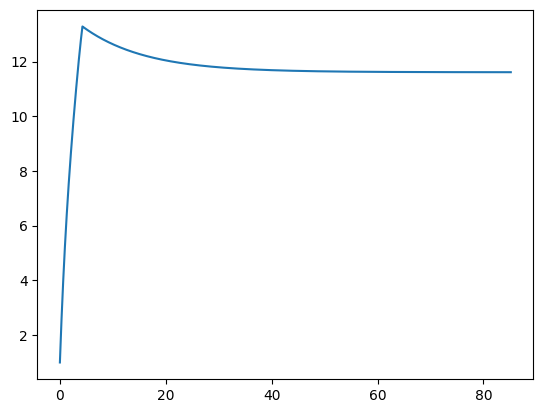

In [354]:
tsol, x2sol = sol.sample(x2, grid='integrator', refine=1000)
plt.plot(tsol, x2sol)
plt.show()

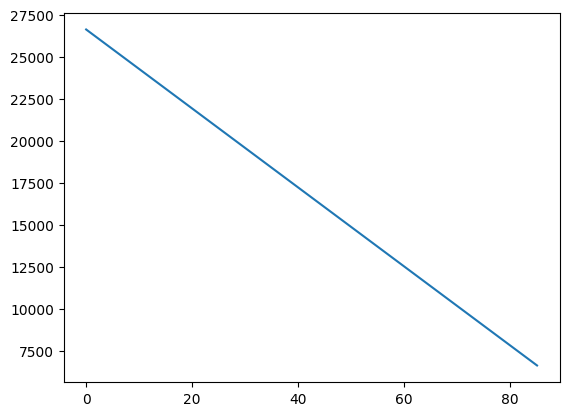

In [355]:
tsol, x3sol = sol.sample(x3, grid='integrator', refine=100)
plt.plot(tsol, x3sol)
plt.show()

In [356]:
tf = sol.sample(ocp.T, grid="control")
print("Final time: ", tf[-1][-1])

Final time:  85.16398430020033


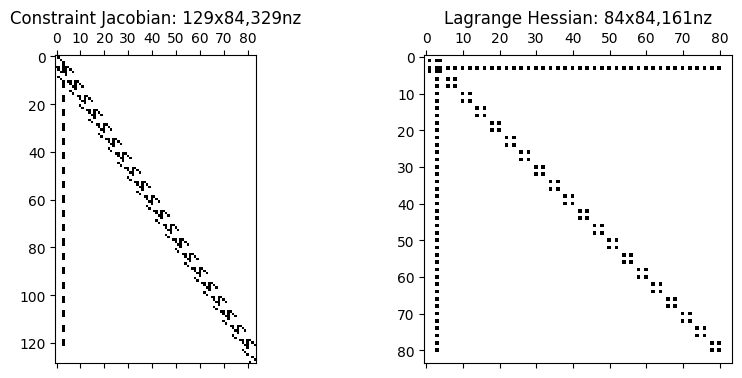

In [357]:
ocp.spy()